In [ ]:
# Code ported from laptop onto 10.12.68.72 starting on 8/24/2020 (Gregory Rouze)

# To-do: 
# 1) need to separate user functions and main code - I have done this successfully in the offline version, but I'm having a
# little more trouble in the cloud version
# 2) Add comments on putpose of individual user functions
# 3) Run a long term experiment this weekend to see if I run into VPN problems (processing will take a while)

# v2 differs from v1 in that excess code that I used to prototype this in the cloud (from my local laptop)
# was removed.


In [1]:
'''Import relevant packages, functions, and user functions used in this reference ET derivation'''

import boto3
from contextlib import contextmanager 
import earthpy.spatial as es
import fsspec
from math import e
import rasterio as rio
import xarray as xr
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
import os
from osgeo import gdal, osr, gdal_array, gdalconst
import pandas as pd
import re
import numpy as np
import sys
import ogr
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
import rioxarray
from shapely.geometry import Point, Polygon
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from matplotlib import pyplot as plt
from rasterio.plot import plotting_extent
import earthpy.plot as ep
import math
from itertools import chain
from ipynb.fs.full.ProjectedReferenceET_Classes_Functions import ET0_PM, aggregate_raster_inmem, resample_raster_write, \
reproject_raster, grepfxn, rastermath, lapply_brick, write_geotiff, atmospheric_pressure, relative_fromspecific, unique, s3_push_delete_local
from ipynb.fs.full.ProjectedReferenceET_Classes_Functions import *
import boto3

'''Set home path if not done so already'''

os.getcwd()
os.chdir('/home/jupyter-rouze')

In [48]:
'''Read configuration file and parse out the inputs line by line'''

# Note that the difference between historical and future outputs in cloud are based on these 2 configuration files.
# configurationfile = 'configurationfile_referenceET_test_future.ini'
configurationfile = 'configurationfile_referenceET_test_historical.ini'

# Note: if you want run rcp 8.5, then all you have to do is change the rcp_source parameter from within config file
# It only affects grepfxn(rcp_source,all_files) below

with open(configurationfile) as f:
    data = {}
    for line in f:
        key, value = line.strip().split(' = ')
        data[key] = value
        
print(data)

model_files = data['model_files']
data_source = data['data_source']
output_folder = data['output_folder']
elevfile = data['elevfile']
tiffolder = data['tiffolder']
ET0_method = data['ET0_method']
ET0_winddat = data['ET0_winddat']
ET0_crop = data['ET0_crop']
to_clip = data['to_clip']
model = data['model']
northmost = float(data['northmost'])
southmost = float(data['southmost'])
westmost = float(data['westmost'])
eastmost = float(data['eastmost'])
pad_factor = float(data['pad_factor'])
rcp_source = data['rcp_source']
MACA_start_bucket = data['MACA_start_bucket']

'''This is needed to retrieve the netCDF files from the dev-et-data AWS bucket'''
# os.chdir(model_files)
fs = fsspec.filesystem(model_files, anon=False, requester_pays=True)

all_files = fs.find(MACA_start_bucket)

# This prints all of the files in dev-et-data/in/DelawareRiverBasin/ or MACA_start_bucket...a big set of outputs, so skipped
# print(all_files)

{'model_files': 's3', 'data_source': 'METDATA', 'output_folder': 'in', 'elevfile': 'in/Elevation/cgiar_srtmmerge.tif', 'tiffolder': 'C:/Users/GRouze/Desktop/ReferenceET_Python/Future-MACA/Individual/geotiffs', 'ET0_method': 'PM', 'ET0_winddat': 'yes', 'ET0_crop': 'short', 'to_clip': 'True', 'model': 'MIROC5', 'northmost': '42.54', 'southmost': '38.6', 'westmost': '-76.3', 'eastmost': '-74.23', 'pad_factor': '0.50', 'rcp_source': 'historical', 'bucket_filepath_root': 'dev-et-data/out/DelawareRiverBasin/', 'bucket_filepath_branch': 'Run08262020_Firstattemptcloudpush', 'MACA_start_bucket': 'dev-et-data/in/DelawareRiverBasin/'}


In [ ]:
# THE CODE BELOW IS PARSED FROM THE CONDIITION WHEN DEALING WITH METDATA

In [49]:
# Split models apart that are to be used for ensemble averaging
models_parsed = [x.strip() for x in model.split(',')]

# Whittle down the number of files if the folder contains both rcp 4.5 and rcp 8.5 files
# Right now, the code can only handle one model of METDATA output (8/21/2020)
rcp_all_files = [grepfxn(rcp_source,all_files)][0]

# Iterate the files by each each specified model
models_list=[]
for i in range(len(models_parsed)):
    model_files_loop = [grepfxn(models_parsed[i],rcp_all_files)][0]
    models_list.append(model_files_loop)
        
# Flatten series of lists into one list
rcp_all_files = list(chain(*models_list))

# prints all netCDF files from 1950-2100 from MACA (radiation, precipitation, wind etc.)
print(rcp_all_files)


['dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1950_1954_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1955_1959_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1960_1964_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1965_1969_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1970_1974_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1975_1979_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1980_1984_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1985_1989_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/PPT/

In [50]:
# Find and compile the year blocks into a list
dfis=[]
for out in rcp_all_files:
    a=out.split('_')
    dfi = a[5]+'_'+a[6]
    dfis.append(dfi)

# print(dfis)
    
# Distill the above list into unique year blocks, as there will be duplicates from multiple climate inputs
year_all=unique(dfis);print(year_all)

# For prototyping only
year_block=0
# print(year_all)
# Print the first entry in the year list
print(year_all[year_block])

['1950_1954', '1955_1959', '1960_1964', '1965_1969', '1970_1974', '1975_1979', '1980_1984', '1985_1989', '1990_1994', '1995_1999', '2000_2004', '2005_2005']
1950_1954


In [51]:
# Take out the components of the for loop below for showcasing to other members of the ET group 

# loop by each block associated with the MACA netCDF file naming structure
for year_block in range(0,len(year_all)):

    year_block_files = grepfxn(year_all[year_block],rcp_all_files)
    
    print(year_block_files)

    bounds=[southmost,northmost,westmost,eastmost]

    rcp_pr = lapply_brick(grepfxn("pr",year_block_files), 'precipitation', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)
    # downwelling shortwave radiation
#     rcp_rsds = lapply_brick(grepfxn("rsds",year_block_files), 'surface_downwelling_shortwave_flux_in_air', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)
    # maximum air temperature
    rcp_tasmax = lapply_brick(grepfxn("tasmax",year_block_files), 'air_temperature', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)
    # minimum air temperature
    rcp_tasmin = lapply_brick(grepfxn("tasmin",year_block_files), 'air_temperature', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)
    # Now repeat above for the rcp 8.5 model outputs below

#     if(data_source == 'METDATA'):

#         rcp_uas = lapply_brick(grepfxn("uas",year_block_files), 'eastward_wind', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)

#         rcp_vas = lapply_brick(grepfxn("vas",year_block_files), 'northward_wind', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)

#         rcp_rhsmax = lapply_brick(grepfxn("rhsmax",year_block_files), 'relative_humidity', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)

#         rcp_rhsmin = lapply_brick(grepfxn("rhsmin",year_block_files), 'relative_humidity', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)

#         # The section below is meant to convert netCDF files into geoTIFFs
        
#     src = rio.open(elevfile)
#     # elevation_full_aggregate = aggregate_raster_inmem(src,scale=0.5)
#     aggoutput_name='elevation_aggregated.tif'
    
#     resample_raster_write(src, name= aggoutput_name,scale=0.5)
    
#     dst_filename='elevation_aggregated_resampled.tif'
#     match_filename=rcp_pr[0][0].name
#     reproject_raster(aggoutput_name, match_filename,dst_filename)
    
#     elevation_array=rio.open(dst_filename).read(1)

    # from datetime import datetime - will need to update to make start/end adaptive (7/28/2020)
#     start_year=year_all[year_block][0:4]
#     end_year=year_all[year_block][5:9]
    start_year=year_all[year_block][0:4]
    end_year=year_all[year_block][5:9]

    start=start_year+'-01-01'
    end=end_year+'-12-31'
    datetimes = pd.date_range(start=start,end=end)
#     i=10
    
    for i in range(0,rcp_pr[0][0].count):

        doy_loop = pd.Period(datetimes[i],freq='D').dayofyear
        year_loop = pd.Period(datetimes[i],freq='D').year

        # step 1: extract ith band from the raster stack
        # step 2: stack those ith bands together
        # step 3: do raster mean math from step 2
        pr_stack=[]

        # Purpose: create stacks of variables individually - this is like brick in R
        pr_ensemble = []
#         rsds_ensemble = []
        tasmax_ensemble = []
        tasmin_ensemble = []

#         j = 0

        # should be 1 array for each variable (mean of x ensembles for a given doy)
        # rcp_pr[0][0].read(1, masked=False).shape
        rcp_pr_doy = rastermath(rcp_pr[0], i)
#         rcp_rsds_doy = rastermath(rcp_rsds[0], i)
        rcp_tasmax_doy = rastermath(rcp_tasmax[0], i)
        rcp_tasmin_doy = rastermath(rcp_tasmin[0], i)

#         dims = np.shape(rcp_pr_doy[0])
#         rows = dims[0]
#         cols = dims[1]
        
        rcp_tasavg_doy = (rcp_tasmax_doy[0] + rcp_tasmin_doy[0])/2
        
#         constant_1_dat = np.full((rows,cols), 17.27)
#         constant_2_dat = np.full((rows,cols), 0.6108)
#         constant_3_dat = np.full((rows,cols), 273.15)
#         constant_4_dat = np.full((rows,cols), 237.3)

#         rcp_vs_tmax_array = constant_2_dat * np.exp(constant_1_dat * (rcp_tasmax_doy[0]-constant_3_dat) / ( (rcp_tasmax_doy[0]-constant_3_dat) + constant_4_dat)) # Equation S2.5
#         rcp_vs_tmin_array = constant_2_dat * np.exp(constant_1_dat * (rcp_tasmin_doy[0]-constant_3_dat) / ( (rcp_tasmin_doy[0]-constant_3_dat) + constant_4_dat)) # Equation S2.5
#         rcp_saturatedvapor_doy = (rcp_vs_tmax_array + rcp_vs_tmin_array)/2 

#         if(data_source == 'METDATA'): # line 180 from R script

#             # All of these are arrays by the way
#             rcp_rhsmax_doy = rastermath(rcp_rhsmax[0], i)
#             rcp_rhsmin_doy = rastermath(rcp_rhsmin[0], i)
#             rcp_uas_doy = rastermath(rcp_uas[0], i)
#             rcp_vas_doy = rastermath(rcp_vas[0], i)

#             # was below are just arrays, not metadata profiles
#             rcp_was_doy_10m = np.sqrt(rcp_uas_doy[0]**2 + rcp_vas_doy[0]**2 )

#             rcp_actualvapor_doy = (rcp_vs_tmin_array * rcp_rhsmax_doy[0]/100 + rcp_vs_tmax_array * rcp_rhsmin_doy[0]/100)/2

#         da = xr.open_rasterio(rcp_pr[1])
#         da_r = rio.open(rcp_pr[1])
#         ny, nx = len(da['y']), len(da['x'])
#         longitude_array, latitude_array = np.meshgrid(da['x'], da['y'])

#         latitude_array_rad = latitude_array * (math.pi/180)

#         # Wind speed at 2 meters
#         z = np.full((rows,cols), 10)
#         array_487 = np.full((rows,cols), 4.87)
#         array_678 = np.full((rows,cols), 67.8)
#         array_542 = np.full((rows,cols), 5.42)

#         if (data_source == 'METDATA'):
#             rcp_was_doy_2m = rcp_was_doy_10m * array_487 / np.log(array_678*z - array_542) # Equation S5.20 for PET formulations other than Penman
#         else:
#             rcp_was_doy_2m = rcp_was_doy_10m[0] * array_487 / np.log(array_678*z - array_542) # Equation S5.20 for PET formulations other than Penman

#         doy_array = np.full((rows,cols), i+1)

        rcp_pr_doy[1]['count']=1
        rcp_tasmin_doy[1]['count']=1
        rcp_tasmax_doy[1]['count']=1

        # To-do: go ahead and developed ET0 directly as opposed to the R implementation(7/29)

#         ET0_inputarrays_rcp = [rcp_pr_doy[0], rcp_rsds_doy[0], rcp_tasmin_doy[0],
#                                      rcp_tasmax_doy[0],rcp_was_doy_2m,rcp_saturatedvapor_doy,
#                                      rcp_actualvapor_doy,elevation_array,latitude_array_rad,doy_array]

#         # NameError: name 'ET0_method' is not defined
#         if ET0_method  == "yes":
#           if ET0_crop != "short" and ET0_crop != "tall":
#             stop("Please enter 'short' or 'tall' for the desired reference crop type")
#           else:
#             alpha = 0.23 # albedo for both short and tall crop
#             if (ET0_crop == "short"):
#               z0 = 0.02 # roughness height for short grass
#             else:
#               z0 = 0.1 # roughness height for tall grass
#         else:
#             z0 = 0.02 # roughness height for short grass
#             alpha = 0.25 # semi-desert short grass - will not be used for calculation - just informative

#         constants=[alpha, z0]

#         ET0_rcp = ET0_PM(ET0_inputarrays_rcp,ET0_method,ET0_winddat,ET0_crop,constants)
#         ET0_rcp.incoming_shortwave()
#         ET0_rcp.outgoing_shortwave()
#         ET0_rcp.outgoing_longwave()
#         ET0_rcp.net_radiation()
#         ET0_rcp_array_from_class = ET0_rcp.ET0_calcs()
#         ET0_rcp_array_final = ET0_rcp_array_from_class.astype('float32')

        rcp_pr_doy[1]['count']=1

        os.chdir('/home/jupyter-rouze')
        # gTIFF_filename = write_geotiff(data=ET0_rcp_array_final,meta=rcp_pr_doy[1],var_name='reference_evapotranspiration',
        #                                doy=doy_loop,year=year_loop,folder=output_folder)
        gTIFF_filename_ppt = write_geotiff(data=rcp_pr_doy[0],meta=rcp_pr_doy[1],var_name='PPT',
                                       doy=doy_loop,year=year_loop,folder=output_folder)
        os.chdir('/home/jupyter-rouze')
        gTIFF_filename_tasavg = write_geotiff(data=rcp_tasavg_doy,meta=rcp_tasmax_doy[1],var_name='Temp',
                                       doy=doy_loop,year=year_loop,folder=output_folder)

        '''Push newly created geoTIFF into specified bucket and its filepath'''

        os.chdir('/home/jupyter-rouze')
        s3_push_delete_local(output_folder+'/' + 'PPT' + '/' + gTIFF_filename_ppt , 'dev-et-data', 
                             'in/DelawareRiverBasin/PPT/'+ str(year_loop)  + '/' + gTIFF_filename_ppt )

        os.chdir('/home/jupyter-rouze')
        s3_push_delete_local(output_folder+'/' + 'Temp' + '/' + gTIFF_filename_tasavg , 'dev-et-data', 
                             'in/DelawareRiverBasin/Temp/'+ str(year_loop)  + '/' + gTIFF_filename_tasavg )


['dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1950_1954_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RAD/Climatology/macav2metdata_rsds_MIROC5_r1i1p1_historical_1950_1954_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RH/RHSMAX/Climatology/macav2metdata_rhsmax_MIROC5_r1i1p1_historical_1950_1954_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RH/RHSMIN/Climatology/macav2metdata_rhsmin_MIROC5_r1i1p1_historical_1950_1954_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/Temp/Climatology/Tmax/macav2metdata_tasmax_MIROC5_r1i1p1_historical_1950_1954_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/Temp/Climatology/Tmin/macav2metdata_tasmin_MIROC5_r1i1p1_historical_1950_1954_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/WIND/UAS/Climatology/macav2metdata_uas_MIROC5_r1i1p1_historical_1950_1954_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/WIND/VAS/Climatology/macav2metdata_vas_MIROC5_r1i1p1_historical_1950_1954_CO

dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950061.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950061.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950062.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950062.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950063.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950063.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950064.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950064.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950065.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950065.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950066.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950066.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950067.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950067.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950068.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950068.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950130.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950130.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950131.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950131.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950132.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950132.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950133.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950133.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950134.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950134.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950135.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950135.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950136.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950136.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950137.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950137.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950199.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950199.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950200.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950200.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950201.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950201.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950202.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950202.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950203.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950203.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950204.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950204.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950205.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950205.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950206.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950206.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950268.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950268.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950269.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950269.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950270.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950270.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950271.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950271.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950272.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950272.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950273.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950273.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950274.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950274.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950275.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950275.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950337.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950337.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950338.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950338.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950339.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950339.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950340.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950340.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950341.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950341.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950342.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950342.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950343.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950343.tif
dev-et-data in/DelawareRiverBasin/PPT/1950/PPT_1950344.tif
dev-et-data in/DelawareRiverBasin/Temp/1950/Temp_1950344.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951041.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951041.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951042.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951042.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951043.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951043.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951044.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951044.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951045.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951045.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951046.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951046.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951047.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951047.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951048.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951048.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951110.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951110.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951111.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951111.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951112.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951112.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951113.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951113.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951114.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951114.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951115.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951115.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951116.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951116.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951117.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951117.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951179.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951179.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951180.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951180.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951181.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951181.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951182.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951182.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951183.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951183.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951184.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951184.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951185.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951185.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951186.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951186.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951248.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951248.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951249.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951249.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951250.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951250.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951251.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951251.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951252.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951252.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951253.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951253.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951254.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951254.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951255.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951255.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951317.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951317.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951318.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951318.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951319.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951319.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951320.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951320.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951321.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951321.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951322.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951322.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951323.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951323.tif
dev-et-data in/DelawareRiverBasin/PPT/1951/PPT_1951324.tif
dev-et-data in/DelawareRiverBasin/Temp/1951/Temp_1951324.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952021.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952021.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952022.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952022.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952023.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952023.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952024.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952024.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952025.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952025.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952026.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952026.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952027.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952027.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952028.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952028.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952090.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952090.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952091.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952091.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952092.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952092.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952093.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952093.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952094.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952094.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952095.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952095.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952096.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952096.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952097.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952097.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952158.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952159.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952159.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952160.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952160.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952161.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952161.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952162.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952162.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952163.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952163.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952164.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952164.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952165.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952165.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952166.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952227.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952227.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952228.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952228.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952229.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952229.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952230.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952230.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952231.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952231.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952232.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952232.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952233.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952233.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952234.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952234.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952296.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952296.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952297.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952297.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952298.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952298.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952299.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952299.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952300.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952300.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952301.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952301.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952302.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952302.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952303.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952303.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952365.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952365.tif
dev-et-data in/DelawareRiverBasin/PPT/1952/PPT_1952366.tif
dev-et-data in/DelawareRiverBasin/Temp/1952/Temp_1952366.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953001.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953001.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953002.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953002.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953003.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953003.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953004.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953004.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953005.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953005.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953006.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953006.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953068.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953068.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953069.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953069.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953070.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953070.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953071.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953071.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953072.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953072.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953073.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953073.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953074.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953074.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953075.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953075.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953137.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953137.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953138.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953138.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953139.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953139.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953140.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953140.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953141.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953141.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953142.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953142.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953143.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953143.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953144.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953144.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953206.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953206.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953207.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953207.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953208.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953208.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953209.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953209.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953210.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953210.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953211.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953211.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953212.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953212.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953213.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953213.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953275.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953275.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953276.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953276.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953277.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953277.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953278.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953278.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953279.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953279.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953280.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953280.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953281.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953281.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953282.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953282.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953344.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953344.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953345.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953345.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953346.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953346.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953347.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953347.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953348.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953348.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953349.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953349.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953350.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953350.tif
dev-et-data in/DelawareRiverBasin/PPT/1953/PPT_1953351.tif
dev-et-data in/DelawareRiverBasin/Temp/1953/Temp_1953351.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954048.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954048.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954049.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954049.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954050.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954050.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954051.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954051.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954052.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954052.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954053.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954053.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954054.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954054.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954055.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954055.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954117.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954117.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954118.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954118.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954119.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954119.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954120.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954120.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954121.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954121.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954122.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954122.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954123.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954123.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954124.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954124.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954186.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954186.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954187.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954187.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954188.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954188.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954189.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954189.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954190.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954190.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954191.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954191.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954192.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954192.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954193.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954193.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954255.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954255.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954256.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954256.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954257.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954257.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954258.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954258.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954259.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954259.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954260.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954260.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954261.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954261.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954262.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954262.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954324.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954324.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954325.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954325.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954326.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954326.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954327.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954327.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954328.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954328.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954329.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954329.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954330.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954330.tif
dev-et-data in/DelawareRiverBasin/PPT/1954/PPT_1954331.tif
dev-et-data in/DelawareRiverBasin/Temp/1954/Temp_1954331.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955019.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955019.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955020.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955020.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955021.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955021.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955022.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955022.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955023.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955023.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955024.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955024.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955025.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955025.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955026.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955026.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955088.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955088.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955089.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955089.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955090.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955090.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955091.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955091.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955092.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955092.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955093.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955093.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955094.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955094.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955095.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955095.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955157.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955157.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955158.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955158.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955159.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955159.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955160.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955160.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955161.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955161.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955162.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955162.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955163.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955163.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955164.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955164.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955225.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955226.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955226.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955227.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955227.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955228.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955228.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955229.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955229.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955230.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955230.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955231.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955231.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955232.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955232.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955233.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955294.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955294.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955295.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955295.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955296.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955296.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955297.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955297.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955298.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955298.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955299.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955299.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955300.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955300.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955301.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955301.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955363.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955363.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955364.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955364.tif
dev-et-data in/DelawareRiverBasin/PPT/1955/PPT_1955365.tif
dev-et-data in/DelawareRiverBasin/Temp/1955/Temp_1955365.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956001.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956001.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956002.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956002.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956003.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956003.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956004.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956004.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956005.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956005.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956067.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956067.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956068.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956068.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956069.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956069.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956070.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956070.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956071.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956071.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956072.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956072.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956073.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956073.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956074.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956074.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956136.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956136.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956137.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956137.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956138.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956138.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956139.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956139.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956140.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956140.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956141.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956141.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956142.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956142.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956143.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956143.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956205.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956205.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956206.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956206.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956207.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956207.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956208.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956208.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956209.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956209.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956210.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956210.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956211.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956211.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956212.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956212.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956274.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956274.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956275.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956275.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956276.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956276.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956277.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956277.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956278.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956278.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956279.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956279.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956280.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956280.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956281.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956281.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956343.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956343.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956344.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956344.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956345.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956345.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956346.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956346.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956347.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956347.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956348.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956348.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956349.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956349.tif
dev-et-data in/DelawareRiverBasin/PPT/1956/PPT_1956350.tif
dev-et-data in/DelawareRiverBasin/Temp/1956/Temp_1956350.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957046.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957046.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957047.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957047.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957048.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957048.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957049.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957049.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957050.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957050.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957051.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957051.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957052.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957052.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957053.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957053.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957115.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957115.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957116.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957116.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957117.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957117.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957118.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957118.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957119.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957119.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957120.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957120.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957121.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957121.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957122.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957122.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957184.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957184.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957185.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957185.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957186.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957186.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957187.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957187.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957188.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957188.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957189.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957189.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957190.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957190.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957191.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957191.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957253.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957253.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957254.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957254.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957255.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957255.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957256.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957256.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957257.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957257.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957258.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957258.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957259.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957259.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957260.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957260.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957322.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957322.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957323.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957323.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957324.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957324.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957325.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957325.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957326.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957326.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957327.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957327.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957328.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957328.tif
dev-et-data in/DelawareRiverBasin/PPT/1957/PPT_1957329.tif
dev-et-data in/DelawareRiverBasin/Temp/1957/Temp_1957329.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958026.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958026.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958027.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958027.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958028.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958028.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958029.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958029.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958030.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958030.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958031.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958031.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958032.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958032.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958033.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958033.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958094.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958095.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958095.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958096.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958096.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958097.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958097.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958098.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958098.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958099.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958099.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958100.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958100.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958101.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958101.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958102.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958163.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958163.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958164.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958164.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958165.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958165.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958166.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958166.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958167.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958167.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958168.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958168.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958169.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958169.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958170.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958170.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958232.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958232.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958233.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958233.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958234.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958234.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958235.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958235.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958236.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958236.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958237.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958237.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958238.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958238.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958239.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958239.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958301.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958301.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958302.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958302.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958303.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958303.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958304.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958304.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958305.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958305.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958306.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958306.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958307.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958307.tif
dev-et-data in/DelawareRiverBasin/PPT/1958/PPT_1958308.tif
dev-et-data in/DelawareRiverBasin/Temp/1958/Temp_1958308.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959005.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959005.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959006.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959006.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959007.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959007.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959008.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959008.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959009.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959009.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959010.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959010.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959011.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959011.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959012.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959012.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959074.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959074.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959075.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959075.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959076.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959076.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959077.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959077.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959078.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959078.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959079.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959079.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959080.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959080.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959081.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959081.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959143.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959143.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959144.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959144.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959145.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959145.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959146.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959146.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959147.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959147.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959148.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959148.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959149.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959149.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959150.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959150.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959212.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959212.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959213.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959213.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959214.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959214.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959215.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959215.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959216.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959216.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959217.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959217.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959218.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959218.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959219.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959219.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959281.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959281.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959282.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959282.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959283.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959283.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959284.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959284.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959285.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959285.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959286.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959286.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959287.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959287.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959288.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959288.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959350.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959350.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959351.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959351.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959352.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959352.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959353.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959353.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959354.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959354.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959355.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959355.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959356.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959356.tif
dev-et-data in/DelawareRiverBasin/PPT/1959/PPT_1959357.tif
dev-et-data in/DelawareRiverBasin/Temp/1959/Temp_1959357.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960045.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960045.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960046.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960046.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960047.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960047.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960048.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960048.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960049.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960049.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960050.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960050.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960051.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960051.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960052.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960052.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960114.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960114.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960115.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960115.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960116.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960116.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960117.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960117.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960118.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960118.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960119.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960119.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960120.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960120.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960121.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960121.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960183.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960183.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960184.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960184.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960185.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960185.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960186.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960186.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960187.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960187.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960188.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960188.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960189.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960189.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960190.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960190.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960252.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960252.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960253.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960253.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960254.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960254.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960255.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960255.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960256.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960256.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960257.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960257.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960258.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960258.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960259.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960259.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960321.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960321.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960322.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960322.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960323.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960323.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960324.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960324.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960325.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960325.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960326.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960326.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960327.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960327.tif
dev-et-data in/DelawareRiverBasin/PPT/1960/PPT_1960328.tif
dev-et-data in/DelawareRiverBasin/Temp/1960/Temp_1960328.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961024.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961024.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961025.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961025.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961026.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961026.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961027.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961027.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961028.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961028.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961029.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961029.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961030.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961030.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961031.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961031.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961093.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961093.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961094.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961094.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961095.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961095.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961096.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961096.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961097.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961097.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961098.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961098.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961099.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961099.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961100.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961100.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961162.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961162.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961163.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961163.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961164.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961164.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961165.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961165.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961166.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961166.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961167.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961167.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961168.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961168.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961169.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961169.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961231.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961231.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961232.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961232.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961233.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961233.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961234.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961234.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961235.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961235.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961236.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961236.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961237.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961237.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961238.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961238.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961300.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961300.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961301.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961301.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961302.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961302.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961303.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961303.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961304.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961304.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961305.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961305.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961306.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961306.tif
dev-et-data in/DelawareRiverBasin/PPT/1961/PPT_1961307.tif
dev-et-data in/DelawareRiverBasin/Temp/1961/Temp_1961307.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962004.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962004.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962005.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962005.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962006.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962006.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962007.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962007.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962008.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962008.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962009.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962009.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962010.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962010.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962011.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962011.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962073.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962073.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962074.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962074.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962075.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962075.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962076.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962076.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962077.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962077.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962078.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962078.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962079.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962079.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962080.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962080.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962141.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962142.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962142.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962143.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962143.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962144.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962144.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962145.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962145.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962146.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962146.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962147.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962147.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962148.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962148.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962149.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962210.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962210.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962211.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962211.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962212.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962212.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962213.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962213.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962214.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962214.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962215.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962215.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962216.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962216.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962217.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962217.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962279.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962279.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962280.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962280.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962281.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962281.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962282.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962282.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962283.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962283.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962284.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962284.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962285.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962285.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962286.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962286.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962348.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962348.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962349.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962349.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962350.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962350.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962351.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962351.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962352.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962352.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962353.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962353.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962354.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962354.tif
dev-et-data in/DelawareRiverBasin/PPT/1962/PPT_1962355.tif
dev-et-data in/DelawareRiverBasin/Temp/1962/Temp_1962355.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963052.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963052.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963053.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963053.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963054.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963054.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963055.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963055.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963056.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963056.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963057.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963057.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963058.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963058.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963059.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963059.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963121.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963121.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963122.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963122.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963123.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963123.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963124.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963124.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963125.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963125.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963126.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963126.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963127.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963127.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963128.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963128.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963190.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963190.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963191.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963191.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963192.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963192.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963193.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963193.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963194.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963194.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963195.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963195.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963196.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963196.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963197.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963197.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963259.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963259.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963260.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963260.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963261.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963261.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963262.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963262.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963263.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963263.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963264.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963264.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963265.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963265.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963266.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963266.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963328.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963328.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963329.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963329.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963330.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963330.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963331.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963331.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963332.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963332.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963333.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963333.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963334.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963334.tif
dev-et-data in/DelawareRiverBasin/PPT/1963/PPT_1963335.tif
dev-et-data in/DelawareRiverBasin/Temp/1963/Temp_1963335.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964032.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964032.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964033.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964033.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964034.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964034.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964035.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964035.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964036.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964036.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964037.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964037.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964038.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964038.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964039.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964039.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964101.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964101.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964102.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964102.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964103.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964103.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964104.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964104.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964105.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964105.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964106.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964106.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964107.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964107.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964108.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964108.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964170.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964170.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964171.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964171.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964172.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964172.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964173.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964173.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964174.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964174.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964175.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964175.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964176.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964176.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964177.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964177.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964239.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964239.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964240.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964240.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964241.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964241.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964242.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964242.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964243.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964243.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964244.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964244.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964245.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964245.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964246.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964246.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964308.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964308.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964309.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964309.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964310.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964310.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964311.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964311.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964312.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964312.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964313.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964313.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964314.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964314.tif
dev-et-data in/DelawareRiverBasin/PPT/1964/PPT_1964315.tif
dev-et-data in/DelawareRiverBasin/Temp/1964/Temp_1964315.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965002.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965002.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965003.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965003.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965004.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965004.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965005.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965005.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965006.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965006.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965007.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965007.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965008.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965008.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965009.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965009.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965071.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965071.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965072.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965072.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965073.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965073.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965074.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965074.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965075.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965075.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965076.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965076.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965077.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965077.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965078.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965078.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965140.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965140.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965141.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965141.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965142.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965142.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965143.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965143.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965144.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965144.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965145.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965145.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965146.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965146.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965147.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965147.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965208.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965209.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965209.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965210.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965210.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965211.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965211.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965212.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965212.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965213.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965213.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965214.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965214.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965215.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965215.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965216.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965277.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965277.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965278.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965278.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965279.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965279.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965280.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965280.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965281.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965281.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965282.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965282.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965283.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965283.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965284.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965284.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965346.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965346.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965347.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965347.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965348.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965348.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965349.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965349.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965350.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965350.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965351.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965351.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965352.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965352.tif
dev-et-data in/DelawareRiverBasin/PPT/1965/PPT_1965353.tif
dev-et-data in/DelawareRiverBasin/Temp/1965/Temp_1965353.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966050.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966050.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966051.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966051.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966052.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966052.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966053.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966053.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966054.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966054.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966055.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966055.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966056.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966056.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966057.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966057.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966118.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966119.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966119.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966120.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966120.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966121.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966121.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966122.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966122.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966123.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966123.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966124.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966124.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966125.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966125.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966126.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966187.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966187.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966188.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966188.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966189.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966189.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966190.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966190.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966191.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966191.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966192.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966192.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966193.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966193.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966194.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966194.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966256.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966256.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966257.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966257.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966258.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966258.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966259.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966259.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966260.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966260.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966261.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966261.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966262.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966262.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966263.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966263.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966325.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966325.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966326.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966326.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966327.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966327.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966328.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966328.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966329.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966329.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966330.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966330.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966331.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966331.tif
dev-et-data in/DelawareRiverBasin/PPT/1966/PPT_1966332.tif
dev-et-data in/DelawareRiverBasin/Temp/1966/Temp_1966332.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967029.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967029.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967030.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967030.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967031.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967031.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967032.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967032.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967033.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967033.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967034.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967034.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967035.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967035.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967036.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967036.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967098.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967098.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967099.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967099.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967100.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967100.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967101.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967101.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967102.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967102.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967103.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967103.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967104.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967104.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967105.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967105.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967167.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967167.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967168.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967168.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967169.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967169.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967170.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967170.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967171.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967171.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967172.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967172.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967173.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967173.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967174.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967174.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967236.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967236.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967237.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967237.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967238.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967238.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967239.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967239.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967240.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967240.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967241.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967241.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967242.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967242.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967243.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967243.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967305.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967305.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967306.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967306.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967307.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967307.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967308.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967308.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967309.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967309.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967310.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967310.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967311.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967311.tif
dev-et-data in/DelawareRiverBasin/PPT/1967/PPT_1967312.tif
dev-et-data in/DelawareRiverBasin/Temp/1967/Temp_1967312.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968009.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968009.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968010.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968010.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968011.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968011.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968012.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968012.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968013.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968013.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968014.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968014.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968015.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968015.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968016.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968016.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968078.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968078.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968079.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968079.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968080.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968080.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968081.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968081.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968082.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968082.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968083.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968083.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968084.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968084.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968085.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968085.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968147.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968147.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968148.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968148.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968149.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968149.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968150.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968150.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968151.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968151.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968152.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968152.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968153.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968153.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968154.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968154.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968216.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968216.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968217.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968217.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968218.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968218.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968219.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968219.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968220.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968220.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968221.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968221.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968222.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968222.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968223.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968223.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968285.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968285.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968286.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968286.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968287.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968287.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968288.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968288.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968289.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968289.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968290.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968290.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968291.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968291.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968292.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968292.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968354.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968354.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968355.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968355.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968356.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968356.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968357.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968357.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968358.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968358.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968359.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968359.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968360.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968360.tif
dev-et-data in/DelawareRiverBasin/PPT/1968/PPT_1968361.tif
dev-et-data in/DelawareRiverBasin/Temp/1968/Temp_1968361.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969057.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969057.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969058.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969058.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969059.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969059.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969060.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969060.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969061.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969061.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969062.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969062.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969063.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969063.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969064.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969064.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969126.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969126.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969127.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969127.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969128.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969128.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969129.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969129.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969130.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969130.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969131.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969131.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969132.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969132.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969133.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969133.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969195.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969195.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969196.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969196.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969197.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969197.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969198.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969198.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969199.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969199.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969200.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969200.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969201.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969201.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969202.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969202.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969264.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969264.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969265.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969265.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969266.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969266.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969267.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969267.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969268.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969268.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969269.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969269.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969270.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969270.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969271.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969271.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969333.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969333.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969334.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969334.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969335.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969335.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969336.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969336.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969337.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969337.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969338.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969338.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969339.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969339.tif
dev-et-data in/DelawareRiverBasin/PPT/1969/PPT_1969340.tif
dev-et-data in/DelawareRiverBasin/Temp/1969/Temp_1969340.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970028.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970028.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970029.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970029.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970030.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970030.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970031.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970031.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970032.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970032.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970033.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970033.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970034.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970034.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970035.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970035.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970097.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970097.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970098.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970098.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970099.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970099.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970100.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970100.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970101.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970101.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970102.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970102.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970103.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970103.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970104.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970104.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970166.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970166.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970167.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970167.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970168.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970168.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970169.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970169.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970170.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970170.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970171.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970171.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970172.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970172.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970173.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970173.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970235.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970235.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970236.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970236.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970237.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970237.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970238.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970238.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970239.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970239.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970240.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970240.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970241.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970241.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970242.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970242.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970304.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970304.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970305.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970305.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970306.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970306.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970307.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970307.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970308.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970308.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970309.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970309.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970310.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970310.tif
dev-et-data in/DelawareRiverBasin/PPT/1970/PPT_1970311.tif
dev-et-data in/DelawareRiverBasin/Temp/1970/Temp_1970311.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971008.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971008.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971009.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971009.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971010.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971010.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971011.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971011.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971012.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971012.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971013.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971013.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971014.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971014.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971015.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971015.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971077.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971077.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971078.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971078.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971079.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971079.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971080.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971080.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971081.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971081.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971082.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971082.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971083.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971083.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971084.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971084.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971145.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971146.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971146.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971147.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971147.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971148.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971148.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971149.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971149.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971150.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971150.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971151.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971151.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971152.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971152.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971153.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971214.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971215.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971215.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971216.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971216.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971217.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971217.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971218.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971218.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971219.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971219.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971220.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971220.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971221.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971221.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971222.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971283.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971284.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971284.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971285.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971285.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971286.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971286.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971287.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971287.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971288.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971288.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971289.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971289.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971290.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971290.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971291.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971352.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971352.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971353.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971353.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971354.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971354.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971355.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971355.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971356.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971356.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971357.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971357.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971358.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971358.tif
dev-et-data in/DelawareRiverBasin/PPT/1971/PPT_1971359.tif
dev-et-data in/DelawareRiverBasin/Temp/1971/Temp_1971359.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972056.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972056.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972057.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972057.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972058.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972058.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972059.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972059.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972060.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972060.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972061.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972061.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972062.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972062.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972063.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972063.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972125.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972125.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972126.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972126.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972127.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972127.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972128.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972128.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972129.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972129.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972130.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972130.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972131.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972131.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972132.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972132.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972194.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972194.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972195.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972195.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972196.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972196.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972197.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972197.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972198.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972198.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972199.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972199.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972200.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972200.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972201.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972201.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972262.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972263.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972263.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972264.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972264.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972265.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972265.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972266.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972266.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972267.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972267.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972268.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972268.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972269.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972269.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972270.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972331.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972331.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972332.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972332.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972333.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972333.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972334.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972334.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972335.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972335.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972336.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972336.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972337.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972337.tif
dev-et-data in/DelawareRiverBasin/PPT/1972/PPT_1972338.tif
dev-et-data in/DelawareRiverBasin/Temp/1972/Temp_1972338.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973034.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973034.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973035.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973035.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973036.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973036.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973037.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973037.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973038.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973038.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973039.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973039.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973040.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973040.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973041.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973041.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973102.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973103.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973103.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973104.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973104.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973105.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973105.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973106.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973106.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973107.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973107.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973108.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973108.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973109.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973109.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973110.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973171.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973171.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973172.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973172.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973173.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973173.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973174.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973174.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973175.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973175.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973176.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973176.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973177.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973177.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973178.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973178.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973240.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973240.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973241.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973241.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973242.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973242.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973243.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973243.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973244.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973244.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973245.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973245.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973246.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973246.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973247.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973247.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973309.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973309.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973310.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973310.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973311.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973311.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973312.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973312.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973313.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973313.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973314.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973314.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973315.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973315.tif
dev-et-data in/DelawareRiverBasin/PPT/1973/PPT_1973316.tif
dev-et-data in/DelawareRiverBasin/Temp/1973/Temp_1973316.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974013.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974013.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974014.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974014.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974015.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974015.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974016.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974016.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974017.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974017.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974018.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974018.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974019.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974019.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974020.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974020.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974082.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974082.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974083.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974083.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974084.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974084.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974085.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974085.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974086.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974086.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974087.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974087.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974088.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974088.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974089.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974089.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974151.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974151.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974152.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974152.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974153.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974153.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974154.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974154.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974155.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974155.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974156.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974156.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974157.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974157.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974158.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974158.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974220.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974220.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974221.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974221.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974222.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974222.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974223.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974223.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974224.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974224.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974225.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974225.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974226.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974226.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974227.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974227.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974289.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974289.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974290.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974290.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974291.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974291.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974292.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974292.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974293.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974293.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974294.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974294.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974295.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974295.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974296.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974296.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974358.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974358.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974359.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974359.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974360.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974360.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974361.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974361.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974362.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974362.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974363.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974363.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974364.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974364.tif
dev-et-data in/DelawareRiverBasin/PPT/1974/PPT_1974365.tif
dev-et-data in/DelawareRiverBasin/Temp/1974/Temp_1974365.tif
['dev-et-data/in/DelawareRiverBasin/PPT/

dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975053.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975053.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975054.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975054.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975055.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975055.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975056.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975056.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975057.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975057.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975058.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975058.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975059.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975059.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975060.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975060.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975122.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975122.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975123.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975123.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975124.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975124.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975125.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975125.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975126.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975126.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975127.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975127.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975128.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975128.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975129.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975129.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975191.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975191.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975192.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975192.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975193.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975193.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975194.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975194.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975195.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975195.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975196.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975196.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975197.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975197.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975198.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975198.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975260.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975260.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975261.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975261.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975262.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975262.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975263.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975263.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975264.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975264.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975265.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975265.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975266.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975266.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975267.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975267.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975329.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975329.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975330.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975330.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975331.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975331.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975332.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975332.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975333.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975333.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975334.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975334.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975335.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975335.tif
dev-et-data in/DelawareRiverBasin/PPT/1975/PPT_1975336.tif
dev-et-data in/DelawareRiverBasin/Temp/1975/Temp_1975336.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976033.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976033.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976034.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976034.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976035.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976035.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976036.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976036.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976037.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976037.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976038.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976038.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976039.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976039.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976040.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976040.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976102.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976102.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976103.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976103.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976104.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976104.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976105.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976105.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976106.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976106.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976107.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976107.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976108.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976108.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976109.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976109.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976171.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976171.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976172.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976172.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976173.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976173.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976174.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976174.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976175.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976175.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976176.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976176.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976177.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976177.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976178.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976178.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976240.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976240.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976241.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976241.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976242.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976242.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976243.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976243.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976244.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976244.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976245.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976245.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976246.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976246.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976247.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976247.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976309.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976309.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976310.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976310.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976311.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976311.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976312.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976312.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976313.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976313.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976314.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976314.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976315.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976315.tif
dev-et-data in/DelawareRiverBasin/PPT/1976/PPT_1976316.tif
dev-et-data in/DelawareRiverBasin/Temp/1976/Temp_1976316.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977012.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977012.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977013.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977013.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977014.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977014.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977015.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977015.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977016.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977016.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977017.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977017.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977018.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977018.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977019.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977019.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977081.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977081.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977082.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977082.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977083.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977083.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977084.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977084.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977085.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977085.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977086.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977086.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977087.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977087.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977088.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977088.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977149.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977150.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977150.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977151.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977151.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977152.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977152.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977153.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977153.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977154.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977154.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977155.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977155.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977156.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977156.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977157.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977218.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977218.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977219.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977219.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977220.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977220.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977221.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977221.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977222.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977222.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977223.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977223.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977224.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977224.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977225.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977225.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977287.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977287.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977288.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977288.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977289.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977289.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977290.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977290.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977291.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977291.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977292.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977292.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977293.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977293.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977294.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977294.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977356.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977356.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977357.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977357.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977358.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977358.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977359.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977359.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977360.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977360.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977361.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977361.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977362.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977362.tif
dev-et-data in/DelawareRiverBasin/PPT/1977/PPT_1977363.tif
dev-et-data in/DelawareRiverBasin/Temp/1977/Temp_1977363.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978060.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978060.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978061.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978061.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978062.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978062.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978063.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978063.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978064.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978064.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978065.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978065.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978066.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978066.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978067.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978067.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978129.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978129.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978130.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978130.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978131.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978131.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978132.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978132.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978133.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978133.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978134.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978134.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978135.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978135.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978136.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978136.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978198.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978198.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978199.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978199.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978200.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978200.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978201.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978201.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978202.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978202.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978203.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978203.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978204.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978204.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978205.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978205.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978267.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978267.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978268.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978268.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978269.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978269.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978270.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978270.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978271.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978271.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978272.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978272.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978273.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978273.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978274.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978274.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978336.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978336.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978337.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978337.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978338.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978338.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978339.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978339.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978340.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978340.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978341.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978341.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978342.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978342.tif
dev-et-data in/DelawareRiverBasin/PPT/1978/PPT_1978343.tif
dev-et-data in/DelawareRiverBasin/Temp/1978/Temp_1978343.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979040.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979040.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979041.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979041.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979042.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979042.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979043.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979043.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979044.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979044.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979045.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979045.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979046.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979046.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979047.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979047.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979109.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979109.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979110.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979110.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979111.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979111.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979112.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979112.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979113.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979113.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979114.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979114.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979115.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979115.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979116.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979116.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979178.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979178.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979179.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979179.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979180.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979180.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979181.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979181.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979182.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979182.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979183.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979183.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979184.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979184.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979185.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979185.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979247.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979247.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979248.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979248.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979249.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979249.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979250.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979250.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979251.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979251.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979252.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979252.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979253.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979253.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979254.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979254.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979316.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979316.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979317.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979317.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979318.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979318.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979319.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979319.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979320.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979320.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979321.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979321.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979322.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979322.tif
dev-et-data in/DelawareRiverBasin/PPT/1979/PPT_1979323.tif
dev-et-data in/DelawareRiverBasin/Temp/1979/Temp_1979323.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980011.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980011.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980012.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980012.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980013.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980013.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980014.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980014.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980015.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980015.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980016.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980016.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980017.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980017.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980018.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980018.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980080.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980080.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980081.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980081.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980082.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980082.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980083.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980083.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980084.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980084.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980085.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980085.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980086.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980086.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980087.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980087.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980148.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980149.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980149.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980150.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980150.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980151.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980151.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980152.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980152.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980153.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980153.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980154.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980154.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980155.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980155.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980156.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980217.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980217.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980218.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980218.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980219.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980219.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980220.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980220.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980221.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980221.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980222.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980222.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980223.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980223.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980224.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980224.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980286.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980286.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980287.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980287.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980288.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980288.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980289.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980289.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980290.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980290.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980291.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980291.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980292.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980292.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980293.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980293.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980355.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980355.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980356.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980356.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980357.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980357.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980358.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980358.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980359.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980359.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980360.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980360.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980361.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980361.tif
dev-et-data in/DelawareRiverBasin/PPT/1980/PPT_1980362.tif
dev-et-data in/DelawareRiverBasin/Temp/1980/Temp_1980362.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981058.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981058.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981059.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981059.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981060.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981060.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981061.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981061.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981062.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981062.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981063.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981063.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981064.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981064.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981065.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981065.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981127.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981127.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981128.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981128.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981129.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981129.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981130.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981130.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981131.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981131.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981132.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981132.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981133.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981133.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981134.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981134.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981196.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981196.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981197.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981197.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981198.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981198.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981199.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981199.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981200.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981200.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981201.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981201.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981202.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981202.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981203.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981203.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981265.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981265.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981266.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981266.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981267.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981267.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981268.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981268.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981269.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981269.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981270.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981270.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981271.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981271.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981272.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981272.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981334.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981334.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981335.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981335.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981336.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981336.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981337.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981337.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981338.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981338.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981339.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981339.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981340.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981340.tif
dev-et-data in/DelawareRiverBasin/PPT/1981/PPT_1981341.tif
dev-et-data in/DelawareRiverBasin/Temp/1981/Temp_1981341.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982038.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982038.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982039.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982039.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982040.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982040.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982041.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982041.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982042.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982042.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982043.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982043.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982044.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982044.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982045.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982045.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982107.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982107.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982108.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982108.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982109.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982109.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982110.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982110.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982111.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982111.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982112.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982112.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982113.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982113.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982114.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982114.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982175.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982176.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982176.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982177.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982177.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982178.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982178.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982179.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982179.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982180.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982180.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982181.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982181.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982182.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982182.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982183.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982244.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982244.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982245.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982245.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982246.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982246.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982247.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982247.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982248.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982248.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982249.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982249.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982250.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982250.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982251.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982251.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982313.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982313.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982314.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982314.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982315.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982315.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982316.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982316.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982317.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982317.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982318.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982318.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982319.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982319.tif
dev-et-data in/DelawareRiverBasin/PPT/1982/PPT_1982320.tif
dev-et-data in/DelawareRiverBasin/Temp/1982/Temp_1982320.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983017.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983017.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983018.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983018.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983019.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983019.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983020.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983020.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983021.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983021.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983022.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983022.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983023.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983023.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983024.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983024.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983086.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983086.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983087.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983087.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983088.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983088.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983089.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983089.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983090.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983090.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983091.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983091.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983092.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983092.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983093.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983093.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983155.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983155.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983156.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983156.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983157.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983157.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983158.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983158.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983159.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983159.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983160.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983160.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983161.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983161.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983162.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983162.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983224.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983224.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983225.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983225.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983226.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983226.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983227.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983227.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983228.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983228.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983229.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983229.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983230.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983230.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983231.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983231.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983293.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983293.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983294.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983294.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983295.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983295.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983296.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983296.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983297.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983297.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983298.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983298.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983299.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983299.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983300.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983300.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983361.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983362.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983362.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983363.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983363.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983364.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983364.tif
dev-et-data in/DelawareRiverBasin/PPT/1983/PPT_1983365.tif
dev-et-data in/DelawareRiverBasin/Temp/1983/Temp_1983365.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984001.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984001.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984002.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984002.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984003.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984003.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984004.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984065.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984066.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984066.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984067.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984067.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984068.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984068.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984069.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984069.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984070.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984070.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984071.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984071.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984072.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984072.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984073.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984134.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984134.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984135.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984135.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984136.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984136.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984137.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984137.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984138.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984138.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984139.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984139.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984140.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984140.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984141.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984141.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984203.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984203.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984204.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984204.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984205.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984205.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984206.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984206.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984207.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984207.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984208.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984208.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984209.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984209.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984210.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984210.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984272.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984272.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984273.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984273.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984274.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984274.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984275.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984275.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984276.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984276.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984277.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984277.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984278.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984278.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984279.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984279.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984340.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984341.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984341.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984342.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984342.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984343.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984343.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984344.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984344.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984345.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984345.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984346.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984346.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984347.tif
dev-et-data in/DelawareRiverBasin/Temp/1984/Temp_1984347.tif
dev-et-data in/DelawareRiverBasin/PPT/1984/PPT_1984348.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985035.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985035.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985036.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985036.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985037.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985037.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985038.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985038.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985039.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985039.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985040.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985040.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985041.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985041.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985042.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985042.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985104.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985104.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985105.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985105.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985106.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985106.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985107.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985107.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985108.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985108.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985109.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985109.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985110.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985110.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985111.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985111.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985173.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985173.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985174.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985174.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985175.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985175.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985176.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985176.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985177.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985177.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985178.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985178.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985179.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985179.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985180.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985180.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985242.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985242.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985243.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985243.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985244.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985244.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985245.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985245.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985246.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985246.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985247.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985247.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985248.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985248.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985249.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985249.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985311.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985311.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985312.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985312.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985313.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985313.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985314.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985314.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985315.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985315.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985316.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985316.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985317.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985317.tif
dev-et-data in/DelawareRiverBasin/PPT/1985/PPT_1985318.tif
dev-et-data in/DelawareRiverBasin/Temp/1985/Temp_1985318.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986014.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986015.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986015.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986016.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986016.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986017.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986017.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986018.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986018.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986019.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986019.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986020.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986020.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986021.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986021.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986022.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986083.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986083.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986084.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986084.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986085.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986085.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986086.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986086.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986087.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986087.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986088.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986088.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986089.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986089.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986090.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986090.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986152.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986152.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986153.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986153.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986154.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986154.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986155.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986155.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986156.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986156.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986157.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986157.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986158.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986158.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986159.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986159.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986221.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986221.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986222.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986222.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986223.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986223.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986224.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986224.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986225.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986225.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986226.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986226.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986227.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986227.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986228.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986228.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986290.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986290.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986291.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986291.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986292.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986292.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986293.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986293.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986294.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986294.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986295.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986295.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986296.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986296.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986297.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986297.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986359.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986359.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986360.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986360.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986361.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986361.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986362.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986362.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986363.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986363.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986364.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986364.tif
dev-et-data in/DelawareRiverBasin/PPT/1986/PPT_1986365.tif
dev-et-data in/DelawareRiverBasin/Temp/1986/Temp_1986365.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987001.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987001.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987063.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987063.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987064.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987064.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987065.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987065.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987066.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987066.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987067.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987067.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987068.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987068.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987069.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987069.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987070.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987070.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987132.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987132.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987133.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987133.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987134.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987134.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987135.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987135.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987136.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987136.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987137.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987137.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987138.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987138.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987139.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987139.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987201.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987201.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987202.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987202.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987203.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987203.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987204.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987204.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987205.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987205.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987206.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987206.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987207.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987207.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987208.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987208.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987270.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987270.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987271.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987271.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987272.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987272.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987273.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987273.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987274.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987274.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987275.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987275.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987276.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987276.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987277.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987277.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987338.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987339.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987339.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987340.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987340.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987341.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987341.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987342.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987342.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987343.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987343.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987344.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987344.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987345.tif
dev-et-data in/DelawareRiverBasin/Temp/1987/Temp_1987345.tif
dev-et-data in/DelawareRiverBasin/PPT/1987/PPT_1987346.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988042.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988042.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988043.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988043.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988044.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988044.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988045.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988045.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988046.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988046.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988047.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988047.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988048.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988048.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988049.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988049.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988111.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988111.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988112.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988112.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988113.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988113.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988114.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988114.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988115.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988115.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988116.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988116.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988117.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988117.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988118.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988118.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988180.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988180.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988181.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988181.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988182.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988182.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988183.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988183.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988184.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988184.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988185.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988185.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988186.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988186.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988187.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988187.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988249.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988249.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988250.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988250.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988251.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988251.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988252.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988252.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988253.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988253.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988254.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988254.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988255.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988255.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988256.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988256.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988318.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988318.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988319.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988319.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988320.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988320.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988321.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988321.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988322.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988322.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988323.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988323.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988324.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988324.tif
dev-et-data in/DelawareRiverBasin/PPT/1988/PPT_1988325.tif
dev-et-data in/DelawareRiverBasin/Temp/1988/Temp_1988325.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989021.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989021.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989022.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989022.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989023.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989023.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989024.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989024.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989025.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989025.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989026.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989026.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989027.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989027.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989028.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989028.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989090.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989090.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989091.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989091.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989092.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989092.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989093.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989093.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989094.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989094.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989095.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989095.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989096.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989096.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989097.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989097.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989159.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989159.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989160.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989160.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989161.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989161.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989162.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989162.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989163.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989163.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989164.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989164.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989165.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989165.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989166.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989166.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989228.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989228.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989229.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989229.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989230.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989230.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989231.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989231.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989232.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989232.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989233.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989233.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989234.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989234.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989235.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989235.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989297.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989297.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989298.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989298.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989299.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989299.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989300.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989300.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989301.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989301.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989302.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989302.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989303.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989303.tif
dev-et-data in/DelawareRiverBasin/PPT/1989/PPT_1989304.tif
dev-et-data in/DelawareRiverBasin/Temp/1989/Temp_1989304.tif
dev-et-data in/DelawareRiverBasin/PPT/19

['dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_historical_1990_1994_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RAD/Climatology/macav2metdata_rsds_MIROC5_r1i1p1_historical_1990_1994_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RH/RHSMAX/Climatology/macav2metdata_rhsmax_MIROC5_r1i1p1_historical_1990_1994_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RH/RHSMIN/Climatology/macav2metdata_rhsmin_MIROC5_r1i1p1_historical_1990_1994_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/Temp/Climatology/Tmax/macav2metdata_tasmax_MIROC5_r1i1p1_historical_1990_1994_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/Temp/Climatology/Tmin/macav2metdata_tasmin_MIROC5_r1i1p1_historical_1990_1994_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/WIND/UAS/Climatology/macav2metdata_uas_MIROC5_r1i1p1_historical_1990_1994_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/WIND/VAS/Climatology/macav2metdata_vas_MIROC5_r1i1p1_historical_1990_1994_CO

dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990061.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990061.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990062.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990062.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990063.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990063.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990064.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990064.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990065.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990065.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990066.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990066.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990067.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990067.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990068.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990068.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990130.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990130.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990131.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990131.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990132.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990132.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990133.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990133.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990134.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990134.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990135.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990135.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990136.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990136.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990137.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990137.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990199.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990199.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990200.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990200.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990201.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990201.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990202.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990202.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990203.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990203.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990204.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990204.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990205.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990205.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990206.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990206.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990268.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990268.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990269.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990269.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990270.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990270.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990271.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990271.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990272.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990272.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990273.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990273.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990274.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990274.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990275.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990275.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990337.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990337.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990338.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990338.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990339.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990339.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990340.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990340.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990341.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990341.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990342.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990342.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990343.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990343.tif
dev-et-data in/DelawareRiverBasin/PPT/1990/PPT_1990344.tif
dev-et-data in/DelawareRiverBasin/Temp/1990/Temp_1990344.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991041.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991041.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991042.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991042.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991043.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991043.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991044.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991044.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991045.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991045.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991046.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991046.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991047.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991047.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991048.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991048.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991109.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991110.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991110.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991111.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991111.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991112.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991112.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991113.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991113.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991114.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991114.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991115.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991115.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991116.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991116.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991117.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991178.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991178.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991179.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991179.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991180.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991180.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991181.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991181.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991182.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991182.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991183.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991183.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991184.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991184.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991185.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991185.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991247.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991247.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991248.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991248.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991249.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991249.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991250.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991250.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991251.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991251.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991252.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991252.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991253.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991253.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991254.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991254.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991316.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991316.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991317.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991317.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991318.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991318.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991319.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991319.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991320.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991320.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991321.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991321.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991322.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991322.tif
dev-et-data in/DelawareRiverBasin/PPT/1991/PPT_1991323.tif
dev-et-data in/DelawareRiverBasin/Temp/1991/Temp_1991323.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992020.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992020.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992021.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992021.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992022.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992022.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992023.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992023.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992024.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992024.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992025.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992025.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992026.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992026.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992027.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992027.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992089.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992089.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992090.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992090.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992091.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992091.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992092.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992092.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992093.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992093.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992094.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992094.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992095.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992095.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992096.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992096.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992158.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992158.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992159.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992159.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992160.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992160.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992161.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992161.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992162.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992162.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992163.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992163.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992164.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992164.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992165.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992165.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992227.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992227.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992228.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992228.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992229.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992229.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992230.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992230.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992231.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992231.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992232.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992232.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992233.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992233.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992234.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992234.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992296.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992296.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992297.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992297.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992298.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992298.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992299.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992299.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992300.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992300.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992301.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992301.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992302.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992302.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992303.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992303.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992365.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992365.tif
dev-et-data in/DelawareRiverBasin/PPT/1992/PPT_1992366.tif
dev-et-data in/DelawareRiverBasin/Temp/1992/Temp_1992366.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993001.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993001.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993002.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993002.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993003.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993003.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993004.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993004.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993005.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993005.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993006.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993006.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993068.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993068.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993069.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993069.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993070.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993070.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993071.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993071.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993072.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993072.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993073.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993073.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993074.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993074.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993075.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993075.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993137.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993137.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993138.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993138.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993139.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993139.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993140.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993140.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993141.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993141.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993142.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993142.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993143.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993143.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993144.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993144.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993206.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993206.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993207.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993207.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993208.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993208.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993209.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993209.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993210.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993210.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993211.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993211.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993212.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993212.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993213.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993213.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993275.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993275.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993276.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993276.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993277.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993277.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993278.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993278.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993279.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993279.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993280.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993280.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993281.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993281.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993282.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993282.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993344.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993344.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993345.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993345.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993346.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993346.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993347.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993347.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993348.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993348.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993349.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993349.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993350.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993350.tif
dev-et-data in/DelawareRiverBasin/PPT/1993/PPT_1993351.tif
dev-et-data in/DelawareRiverBasin/Temp/1993/Temp_1993351.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994048.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994048.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994049.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994049.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994050.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994050.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994051.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994051.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994052.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994052.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994053.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994053.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994054.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994054.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994055.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994055.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994117.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994117.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994118.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994118.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994119.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994119.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994120.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994120.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994121.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994121.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994122.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994122.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994123.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994123.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994124.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994124.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994186.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994186.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994187.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994187.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994188.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994188.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994189.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994189.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994190.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994190.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994191.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994191.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994192.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994192.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994193.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994193.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994255.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994255.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994256.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994256.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994257.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994257.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994258.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994258.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994259.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994259.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994260.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994260.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994261.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994261.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994262.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994262.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994324.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994324.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994325.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994325.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994326.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994326.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994327.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994327.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994328.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994328.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994329.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994329.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994330.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994330.tif
dev-et-data in/DelawareRiverBasin/PPT/1994/PPT_1994331.tif
dev-et-data in/DelawareRiverBasin/Temp/1994/Temp_1994331.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995019.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995019.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995020.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995020.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995021.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995021.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995022.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995022.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995023.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995023.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995024.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995024.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995025.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995025.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995026.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995026.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995088.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995088.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995089.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995089.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995090.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995090.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995091.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995091.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995092.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995092.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995093.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995093.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995094.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995094.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995095.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995095.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995157.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995157.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995158.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995158.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995159.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995159.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995160.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995160.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995161.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995161.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995162.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995162.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995163.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995163.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995164.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995164.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995226.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995226.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995227.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995227.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995228.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995228.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995229.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995229.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995230.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995230.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995231.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995231.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995232.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995232.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995233.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995233.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995295.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995295.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995296.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995296.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995297.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995297.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995298.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995298.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995299.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995299.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995300.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995300.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995301.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995301.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995302.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995302.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995364.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995364.tif
dev-et-data in/DelawareRiverBasin/PPT/1995/PPT_1995365.tif
dev-et-data in/DelawareRiverBasin/Temp/1995/Temp_1995365.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996001.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996001.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996002.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996002.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996003.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996003.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996004.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996004.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996005.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996005.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996006.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996006.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996068.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996068.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996069.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996069.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996070.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996070.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996071.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996071.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996072.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996072.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996073.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996073.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996074.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996074.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996075.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996075.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996137.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996137.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996138.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996138.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996139.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996139.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996140.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996140.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996141.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996141.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996142.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996142.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996143.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996143.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996144.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996144.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996206.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996206.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996207.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996207.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996208.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996208.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996209.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996209.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996210.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996210.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996211.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996211.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996212.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996212.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996213.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996213.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996274.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996275.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996275.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996276.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996276.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996277.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996277.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996278.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996278.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996279.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996279.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996280.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996280.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996281.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996281.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996282.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996343.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996343.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996344.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996344.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996345.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996345.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996346.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996346.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996347.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996347.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996348.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996348.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996349.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996349.tif
dev-et-data in/DelawareRiverBasin/PPT/1996/PPT_1996350.tif
dev-et-data in/DelawareRiverBasin/Temp/1996/Temp_1996350.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997045.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997046.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997046.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997047.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997047.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997048.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997048.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997049.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997049.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997050.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997050.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997051.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997051.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997052.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997052.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997053.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997114.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997114.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997115.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997115.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997116.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997116.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997117.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997117.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997118.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997118.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997119.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997119.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997120.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997120.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997121.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997121.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997183.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997183.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997184.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997184.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997185.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997185.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997186.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997186.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997187.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997187.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997188.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997188.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997189.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997189.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997190.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997190.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997252.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997252.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997253.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997253.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997254.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997254.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997255.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997255.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997256.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997256.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997257.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997257.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997258.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997258.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997259.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997259.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997321.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997321.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997322.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997322.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997323.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997323.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997324.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997324.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997325.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997325.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997326.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997326.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997327.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997327.tif
dev-et-data in/DelawareRiverBasin/PPT/1997/PPT_1997328.tif
dev-et-data in/DelawareRiverBasin/Temp/1997/Temp_1997328.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998025.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998025.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998026.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998026.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998027.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998027.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998028.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998028.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998029.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998029.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998030.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998030.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998031.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998031.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998032.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998032.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998094.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998094.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998095.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998095.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998096.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998096.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998097.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998097.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998098.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998098.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998099.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998099.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998100.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998100.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998101.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998101.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998163.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998163.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998164.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998164.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998165.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998165.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998166.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998166.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998167.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998167.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998168.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998168.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998169.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998169.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998170.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998170.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998232.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998232.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998233.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998233.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998234.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998234.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998235.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998235.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998236.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998236.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998237.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998237.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998238.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998238.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998239.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998239.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998301.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998301.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998302.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998302.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998303.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998303.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998304.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998304.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998305.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998305.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998306.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998306.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998307.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998307.tif
dev-et-data in/DelawareRiverBasin/PPT/1998/PPT_1998308.tif
dev-et-data in/DelawareRiverBasin/Temp/1998/Temp_1998308.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999004.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999005.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999005.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999006.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999006.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999007.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999007.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999008.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999008.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999009.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999009.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999010.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999010.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999011.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999011.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999012.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999073.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999073.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999074.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999074.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999075.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999075.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999076.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999076.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999077.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999077.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999078.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999078.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999079.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999079.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999080.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999080.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999142.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999142.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999143.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999143.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999144.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999144.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999145.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999145.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999146.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999146.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999147.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999147.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999148.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999148.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999149.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999149.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999211.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999211.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999212.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999212.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999213.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999213.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999214.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999214.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999215.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999215.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999216.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999216.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999217.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999217.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999218.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999218.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999280.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999280.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999281.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999281.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999282.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999282.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999283.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999283.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999284.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999284.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999285.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999285.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999286.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999286.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999287.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999287.tif
dev-et-data in/DelawareRiverBasin/PPT/19

dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999348.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999349.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999349.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999350.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999350.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999351.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999351.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999352.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999352.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999353.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999353.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999354.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999354.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999355.tif
dev-et-data in/DelawareRiverBasin/Temp/1999/Temp_1999355.tif
dev-et-data in/DelawareRiverBasin/PPT/1999/PPT_1999356.tif
dev-et-data in/DelawareRiverBasin/Temp/1

dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000044.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000044.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000045.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000045.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000046.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000046.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000047.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000047.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000048.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000048.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000049.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000049.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000050.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000050.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000051.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000051.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000112.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000113.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000113.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000114.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000114.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000115.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000115.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000116.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000116.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000117.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000117.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000118.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000118.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000119.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000119.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000120.tif
dev-et-data in/DelawareRiverBasin/Temp/2

dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000181.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000181.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000182.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000182.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000183.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000183.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000184.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000184.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000185.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000185.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000186.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000186.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000187.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000187.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000188.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000188.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000250.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000250.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000251.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000251.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000252.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000252.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000253.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000253.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000254.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000254.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000255.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000255.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000256.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000256.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000257.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000257.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000319.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000319.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000320.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000320.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000321.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000321.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000322.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000322.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000323.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000323.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000324.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000324.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000325.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000325.tif
dev-et-data in/DelawareRiverBasin/PPT/2000/PPT_2000326.tif
dev-et-data in/DelawareRiverBasin/Temp/2000/Temp_2000326.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001022.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001022.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001023.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001023.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001024.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001024.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001025.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001025.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001026.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001026.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001027.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001027.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001028.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001028.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001029.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001029.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001090.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001091.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001091.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001092.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001092.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001093.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001093.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001094.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001094.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001095.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001095.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001096.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001096.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001097.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001097.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001098.tif
dev-et-data in/DelawareRiverBasin/Temp/2

dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001159.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001159.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001160.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001160.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001161.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001161.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001162.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001162.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001163.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001163.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001164.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001164.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001165.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001165.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001166.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001166.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001228.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001228.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001229.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001229.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001230.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001230.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001231.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001231.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001232.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001232.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001233.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001233.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001234.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001234.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001235.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001235.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001297.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001297.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001298.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001298.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001299.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001299.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001300.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001300.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001301.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001301.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001302.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001302.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001303.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001303.tif
dev-et-data in/DelawareRiverBasin/PPT/2001/PPT_2001304.tif
dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001304.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/Temp/2001/Temp_2001365.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002001.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002001.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002002.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002002.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002003.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002003.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002004.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002004.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002005.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002005.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002006.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002006.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002007.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002007.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002008.tif
dev-et-data in/DelawareRiverBasin/Temp/2

dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002069.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002070.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002070.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002071.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002071.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002072.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002072.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002073.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002073.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002074.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002074.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002075.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002075.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002076.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002076.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002077.tif
dev-et-data in/DelawareRiverBasin/Temp/2

dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002138.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002138.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002139.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002139.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002140.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002140.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002141.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002141.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002142.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002142.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002143.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002143.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002144.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002144.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002145.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002145.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002207.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002207.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002208.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002208.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002209.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002209.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002210.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002210.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002211.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002211.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002212.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002212.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002213.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002213.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002214.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002214.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002276.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002276.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002277.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002277.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002278.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002278.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002279.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002279.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002280.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002280.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002281.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002281.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002282.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002282.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002283.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002283.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002344.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002345.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002345.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002346.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002346.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002347.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002347.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002348.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002348.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002349.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002349.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002350.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002350.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002351.tif
dev-et-data in/DelawareRiverBasin/Temp/2002/Temp_2002351.tif
dev-et-data in/DelawareRiverBasin/PPT/2002/PPT_2002352.tif
dev-et-data in/DelawareRiverBasin/Temp/2

dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003048.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003048.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003049.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003049.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003050.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003050.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003051.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003051.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003052.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003052.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003053.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003053.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003054.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003054.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003055.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003055.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003116.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003117.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003117.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003118.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003118.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003119.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003119.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003120.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003120.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003121.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003121.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003122.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003122.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003123.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003123.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003124.tif
dev-et-data in/DelawareRiverBasin/Temp/2

dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003185.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003185.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003186.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003186.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003187.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003187.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003188.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003188.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003189.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003189.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003190.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003190.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003191.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003191.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003192.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003192.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003254.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003254.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003255.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003255.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003256.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003256.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003257.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003257.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003258.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003258.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003259.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003259.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003260.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003260.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003261.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003261.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003323.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003323.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003324.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003324.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003325.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003325.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003326.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003326.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003327.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003327.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003328.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003328.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003329.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003329.tif
dev-et-data in/DelawareRiverBasin/PPT/2003/PPT_2003330.tif
dev-et-data in/DelawareRiverBasin/Temp/2003/Temp_2003330.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004026.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004027.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004027.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004028.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004028.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004029.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004029.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004030.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004030.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004031.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004031.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004032.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004032.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004033.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004033.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004034.tif
dev-et-data in/DelawareRiverBasin/Temp/2

dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004095.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004095.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004096.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004096.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004097.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004097.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004098.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004098.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004099.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004099.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004100.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004100.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004101.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004101.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004102.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004102.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004164.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004164.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004165.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004165.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004166.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004166.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004167.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004167.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004168.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004168.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004169.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004169.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004170.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004170.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004171.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004171.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004233.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004233.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004234.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004234.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004235.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004235.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004236.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004236.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004237.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004237.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004238.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004238.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004239.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004239.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004240.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004240.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004302.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004302.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004303.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004303.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004304.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004304.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004305.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004305.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004306.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004306.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004307.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004307.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004308.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004308.tif
dev-et-data in/DelawareRiverBasin/PPT/2004/PPT_2004309.tif
dev-et-data in/DelawareRiverBasin/Temp/2004/Temp_2004309.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005001.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005001.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005002.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005002.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005003.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005003.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005004.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005004.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005005.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005005.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005006.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005006.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005007.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005007.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005008.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005008.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005069.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005070.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005070.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005071.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005071.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005072.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005072.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005073.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005073.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005074.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005074.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005075.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005075.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005076.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005076.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005077.tif
dev-et-data in/DelawareRiverBasin/Temp/2

dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005138.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005138.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005139.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005139.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005140.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005140.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005141.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005141.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005142.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005142.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005143.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005143.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005144.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005144.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005145.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005145.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005207.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005207.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005208.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005208.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005209.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005209.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005210.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005210.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005211.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005211.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005212.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005212.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005213.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005213.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005214.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005214.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005276.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005276.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005277.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005277.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005278.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005278.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005279.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005279.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005280.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005280.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005281.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005281.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005282.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005282.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005283.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005283.tif
dev-et-data in/DelawareRiverBasin/PPT/20

dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005344.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005345.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005345.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005346.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005346.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005347.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005347.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005348.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005348.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005349.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005349.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005350.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005350.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005351.tif
dev-et-data in/DelawareRiverBasin/Temp/2005/Temp_2005351.tif
dev-et-data in/DelawareRiverBasin/PPT/2005/PPT_2005352.tif
dev-et-data in/DelawareRiverBasin/Temp/2

In [ ]:
##################### Break down for loop by components for showcasing

In [5]:
# range(0,len(year_all))
year_block_files = grepfxn(year_all[0],rcp_all_files)
print(year_block_files)

bounds=[southmost,northmost,westmost,eastmost]

'''For a given input netCDF file, lapplybrick() creates a rasterio object that is clipped specifically for Delaware'''

rcp_pr = lapply_brick(grepfxn("pr",year_block_files), 'precipitation', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)
# downwelling shortwave radiation
# rcp_rsds = lapply_brick(grepfxn("rsds",year_block_files), 'surface_downwelling_shortwave_flux_in_air', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)
# maximum air temperature
rcp_tasmax = lapply_brick(grepfxn("tasmax",year_block_files), 'air_temperature', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)
# minimum air temperature
rcp_tasmin = lapply_brick(grepfxn("tasmin",year_block_files), 'air_temperature', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)
# Now repeat above for the rcp 8.5 model outputs below

# if(data_source == 'METDATA'):

#     rcp_uas = lapply_brick(grepfxn("uas",year_block_files), 'eastward_wind', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)

#     rcp_vas = lapply_brick(grepfxn("vas",year_block_files), 'northward_wind', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)

#     rcp_rhsmax = lapply_brick(grepfxn("rhsmax",year_block_files), 'relative_humidity', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)

#     rcp_rhsmin = lapply_brick(grepfxn("rhsmin",year_block_files), 'relative_humidity', model_files,tiffolder,data_source,to_clip=to_clip,bounds=bounds,pad_factor=pad_factor)

#     # The section below is meant to convert netCDF files into geoTIFFs

print(rcp_pr)

['dev-et-data/in/DelawareRiverBasin/PPT/Climatology/macav2metdata_pr_MIROC5_r1i1p1_rcp45_2006_2010_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RAD/Climatology/macav2metdata_rsds_MIROC5_r1i1p1_rcp45_2006_2010_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RH/RHSMAX/Climatology/macav2metdata_rhsmax_MIROC5_r1i1p1_rcp45_2006_2010_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/RH/RHSMIN/Climatology/macav2metdata_rhsmin_MIROC5_r1i1p1_rcp45_2006_2010_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/Temp/Climatology/Tmax/macav2metdata_tasmax_MIROC5_r1i1p1_rcp45_2006_2010_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/Temp/Climatology/Tmin/macav2metdata_tasmin_MIROC5_r1i1p1_rcp45_2006_2010_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/WIND/UAS/Climatology/macav2metdata_uas_MIROC5_r1i1p1_rcp45_2006_2010_CONUS_daily.nc', 'dev-et-data/in/DelawareRiverBasin/WIND/VAS/Climatology/macav2metdata_vas_MIROC5_r1i1p1_rcp45_2006_2010_CONUS_daily.nc']
([<open DatasetReader nam

In [6]:
# '''Read and resample elevation to match raster characteristics from all other MACA inputs needed for reference ET'''

# src = rio.open(elevfile)
# # elevation_full_aggregate = aggregate_raster_inmem(src,scale=0.5)
# aggoutput_name='elevation_aggregated.tif'

# resample_raster_write(src, name= aggoutput_name,scale=0.5)

# dst_filename='elevation_aggregated_resampled.tif'
# match_filename=rcp_pr[0][0].name
# reproject_raster(aggoutput_name, match_filename,dst_filename)

# elevation_array=rio.open(dst_filename).read(1)

# from datetime import datetime - will need to update to make start/end adaptive (7/28/2020)
start_year=year_all[year_block][0:4]
end_year=year_all[year_block][5:9]

start=start_year+'-01-01'
end=end_year+'-12-31'
datetimes = pd.date_range(start=start,end=end)
# i=10

print(start)
print(end)

2006-01-01
2010-12-31


In [7]:
# for i in range(0,rcp_pr[0][0].count):
    
doy_loop = pd.Period(datetimes[0],freq='D').dayofyear
year_loop = pd.Period(datetimes[0],freq='D').year

print(doy_loop)
print(year_loop)

# step 1: extract ith band from the raster stack
# step 2: stack those ith bands together
# step 3: do raster mean math from step 2
pr_stack=[]

# Purpose: create stacks of variables individually - this is like brick in R
pr_ensemble = []
# rsds_ensemble = []
tasmax_ensemble = []
tasmin_ensemble = []


1
2006


In [46]:
# Here we are using index = 0 or January 1 of the first year in the given netCDF file (e.g. 2021, 2026 2031, 2036 etc.)

# should be 1 array for each variable (mean of x ensembles for a given doy)
# rcp_pr[0][0].read(1, masked=False).shape

# print(rcp_pr[0]) # rasterio opened geoTIFF of precipitation 

'''rastermath() averages across all models...however, since we are only dealing with one model for now (i.e. MIROC5),
the rastermath() APPEARS to be redundant. However, future iterations of this code, such as rastermath(), are expecting
an ensemble average of inputs, which are better for to gauge model uncertainty.'''
rcp_pr_doy = rastermath(rcp_pr[0], i)

# print(rcp_pr_doy)
print(rcp_pr_doy[0]) # array
print(rcp_pr_doy[1]) # geoTIFF metadata

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.9990000e+03
  -9.9990000e+03 -9.9990000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.9990000e+03
  -9.9990000e+03 -9.9990000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.9990000e+03
  -9.9990000e+03 -9.9990000e+03]
 ...
 [ 1.4635136e+00  1.3776451e+00  1.2891870e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.4311470e+00  1.3430346e+00  1.3570224e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3925924e+00  1.3432311e+00  1.3105971e+00 ...  3.4409872e-01
   3.0470088e-01  2.9649755e-01]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 74, 'height': 119, 'count': 1826, 'crs': None, 'transform': Affine(0.04166610926797945, 0.0, -76.793782273384,
       0.0, 0.041665998555846136, 38.083704964589266), 'tiled': False, 'interleave': 'pixel'}


In [13]:
'''Repeat rastermath() for all other inputs needed for reference ET'''

# rcp_rsds_doy = rastermath(rcp_rsds[0], i)
rcp_tasmax_doy = rastermath(rcp_tasmax[0], i)
rcp_tasmin_doy = rastermath(rcp_tasmin[0], i)

print(rcp_tasmax_doy)

dims = np.shape(rcp_pr_doy[0])
rows = dims[0]
cols = dims[1]

rcp_tasavg_doy = (rcp_tasmax_doy[0] + rcp_tasmin_doy[0])/2

print(rcp_tasavg_doy)

# '''Derive saturated vapor pressure for Penman-Monteith Approximation'''

# constant_1_dat = np.full((rows,cols), 17.27)
# constant_2_dat = np.full((rows,cols), 0.6108)
# constant_3_dat = np.full((rows,cols), 273.15)
# constant_4_dat = np.full((rows,cols), 237.3)

# rcp_vs_tmax_array = constant_2_dat * np.exp(constant_1_dat * (rcp_tasmax_doy[0]-constant_3_dat) / ( (rcp_tasmax_doy[0]-constant_3_dat) + constant_4_dat)) # Equation S2.5
# rcp_vs_tmin_array = constant_2_dat * np.exp(constant_1_dat * (rcp_tasmin_doy[0]-constant_3_dat) / ( (rcp_tasmin_doy[0]-constant_3_dat) + constant_4_dat)) # Equation S2.5
# rcp_saturatedvapor_doy = (rcp_vs_tmax_array + rcp_vs_tmin_array)/2 # s2.6


(array([[  278.87607,   279.25024,   279.2576 , ..., -9999.     ,
        -9999.     , -9999.     ],
       [  278.73468,   279.02814,   279.0599 , ..., -9999.     ,
        -9999.     , -9999.     ],
       [  278.57953,   278.9089 ,   278.82556, ..., -9999.     ,
        -9999.     , -9999.     ],
       ...,
       [  274.581  ,   274.549  ,   274.4946 , ...,   273.57706,
          273.61722,   273.50595],
       [  274.45746,   274.37674,   274.39127, ...,   273.6974 ,
          273.6947 ,   273.5874 ],
       [  274.16647,   274.07   ,   274.08902, ...,   273.90634,
          273.91592,   273.79184]], dtype=float32), {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 74, 'height': 119, 'count': 1826, 'crs': None, 'transform': Affine(0.04166610926797945, 0.0, -76.793782273384,
       0.0, 0.041665998555846136, 38.083704964589266), 'tiled': False, 'interleave': 'pixel'})
[[  274.2751    274.5924    274.59576 ... -9999.      -9999.
  -9999.     ]
 [  274.27344   274.

In [ ]:
# if(data_source == 'METDATA'): # line 180 from R script

#     # All of these are arrays by the way
#     rcp_rhsmax_doy = rastermath(rcp_rhsmax[0], i)
#     rcp_rhsmin_doy = rastermath(rcp_rhsmin[0], i)
#     rcp_uas_doy = rastermath(rcp_uas[0], i)
#     rcp_vas_doy = rastermath(rcp_vas[0], i)

#     # was below are just arrays, not metadata profiles
#     rcp_was_doy_10m = np.sqrt(rcp_uas_doy[0]**2 + rcp_vas_doy[0]**2 )

#     # inputs: min/max saturated vapor pressure from air temp., min/max relative humidity (assuming relative humidity is present)
#     rcp_actualvapor_doy = (rcp_vs_tmin_array * rcp_rhsmax_doy[0]/100 + rcp_vs_tmax_array * rcp_rhsmin_doy[0]/100)/2 # s2.7


In [ ]:
# da = xr.open_rasterio(rcp_pr[1])
# da_r = rio.open(rcp_pr[1])
# ny, nx = len(da['y']), len(da['x'])
# longitude_array, latitude_array = np.meshgrid(da['x'], da['y'])

# # Latitude (needed for Extraterrestrial radiation or Ra), in radians
# latitude_array_rad = latitude_array * (math.pi/180)

# # Convert from wind speed at 10 meters to wind speed at 2 meters
# z = np.full((rows,cols), 10)
# array_487 = np.full((rows,cols), 4.87)
# array_678 = np.full((rows,cols), 67.8)
# array_542 = np.full((rows,cols), 5.42)

# if (data_source == 'METDATA'):
#     rcp_was_doy_2m = rcp_was_doy_10m * array_487 / np.log(array_678*z - array_542) # Equation S5.20 for PET formulations other than Penman
# else:
#     rcp_was_doy_2m = rcp_was_doy_10m[0] * array_487 / np.log(array_678*z - array_542) # Equation S5.20 for PET formulations other than Penman

# doy_array = np.full((rows,cols), i+1)

rcp_pr_doy[1]['count']=1
rcp_tasmin_doy[1]['count']=1
rcp_tasmax_doy[1]['count']=1

# To-do: go ahead and developed ET0 directly as opposed to the R implementation(7/29)

In [ ]:
# # To-do: go ahead and developed ET0 directly as opposed to the R implementation(7/29)

# # Combine all of the inputs into an list of arrays

# ET0_inputarrays_rcp = [rcp_pr_doy[0], rcp_rsds_doy[0], rcp_tasmin_doy[0],
#                              rcp_tasmax_doy[0],rcp_was_doy_2m,rcp_saturatedvapor_doy,
#                              rcp_actualvapor_doy,elevation_array,latitude_array_rad,doy_array]

# # NameError: name 'ET0_method' is not defined
# if ET0_method  == "yes":
#   if ET0_crop != "short" and ET0_crop != "tall":
#     stop("Please enter 'short' or 'tall' for the desired reference crop type")
#   else:
#     alpha = 0.23 # albedo for both short and tall crop
#     if (ET0_crop == "short"):
#       z0 = 0.02 # roughness height for short grass
#     else:
#       z0 = 0.1 # roughness height for tall grass
# else:
#     z0 = 0.02 # roughness height for short grass
#     alpha = 0.25 # semi-desert short grass - will not be used for calculation - just informative

# constants=[alpha, z0]

# '''Initialize the ET0 class from the imported  Jupyter notebook external to this one (see top for imports)'''
# ET0_rcp = ET0_PM(ET0_inputarrays_rcp,ET0_method,ET0_winddat,ET0_crop,constants)
# ET0_rcp.incoming_shortwave()
# ET0_rcp.outgoing_shortwave()
# ET0_rcp.outgoing_longwave()
# ET0_rcp.net_radiation()
# ET0_rcp_array_from_class = ET0_rcp.ET0_calcs()
# ET0_rcp_array_final = ET0_rcp_array_from_class.astype('float32')

In [ ]:
# print(ET0_rcp_array_final)

# result = ET0_rcp_array_final.ravel() 
# cleanedList = [x for x in result if str(x) != 'nan']

# from scipy import stats
# stats.describe(cleanedList)

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(ET0_rcp_array_final)
# plt.show()
# plt.title("Histogram with 'auto' bins")
# plt.hist(ET0_rcp_array_final)
# plt.show()

In [18]:
# print(ET0_rcp_array_final)
print(rcp_pr_doy[0])
print(rcp_tasavg_doy)
print(rcp_pr_doy[1])
print(rcp_tasmax_doy[1])

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.9990000e+03
  -9.9990000e+03 -9.9990000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.9990000e+03
  -9.9990000e+03 -9.9990000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.9990000e+03
  -9.9990000e+03 -9.9990000e+03]
 ...
 [ 1.4635136e+00  1.3776451e+00  1.2891870e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.4311470e+00  1.3430346e+00  1.3570224e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3925924e+00  1.3432311e+00  1.3105971e+00 ...  3.4409872e-01
   3.0470088e-01  2.9649755e-01]]
[[  274.2751    274.5924    274.59576 ... -9999.      -9999.
  -9999.     ]
 [  274.27344   274.5522    274.53827 ... -9999.      -9999.
  -9999.     ]
 [  274.13635   274.39966   274.37183 ... -9999.      -9999.
  -9999.     ]
 ...
 [  269.59238   269.6041    269.54343 ...   268.63922   268.7032
    268.5407 ]
 [  269.4634    269.44385   269.46857 ...   268.66272   268.6599
    268.52985]
 [  269

In [23]:
# rcp_pr_doy[1]['count']=1

os.chdir('/home/jupyter-rouze')
# gTIFF_filename = write_geotiff(data=ET0_rcp_array_final,meta=rcp_pr_doy[1],var_name='reference_evapotranspiration',
#                                doy=doy_loop,year=year_loop,folder=output_folder)
gTIFF_filename_ppt = write_geotiff(data=rcp_pr_doy[0],meta=rcp_pr_doy[1],var_name='PPT',
                               doy=doy_loop,year=year_loop,folder=output_folder)
os.chdir('/home/jupyter-rouze')
gTIFF_filename_tasavg = write_geotiff(data=rcp_tasavg_doy,meta=rcp_tasmax_doy[1],var_name='Temp',
                               doy=doy_loop,year=year_loop,folder=output_folder)


In [20]:
print(output_folder)
print(gTIFF_filename_ppt)

in
PPT_2006001.tif


In [24]:
# local_file = output_folder+'/' + 'reference_evapotranspiration' + '/' + gTIFF_filename 
# bucket = 'dev-et-data'
# bucket_filepath = 'in/DelawareRiverBasin/ETo/'+ str(year_loop)  + '/' + gTIFF_filename 

# s3_push_delete_local(output_folder+'/' + 'reference_evapotranspiration' + '/' + gTIFF_filename , 'dev-et-data', 
#                      'in/DelawareRiverBasin/ETo/'+ str(year_loop)  + '/' + gTIFF_filename )

'''Push newly created geoTIFF into specified bucket and its filepath'''

os.chdir('/home/jupyter-rouze')
s3_push_delete_local(output_folder+'/' + 'PPT' + '/' + gTIFF_filename_ppt , 'dev-et-data', 
                     'in/DelawareRiverBasin/PPT/'+ str(year_loop)  + '/' + gTIFF_filename_ppt )

os.chdir('/home/jupyter-rouze')
s3_push_delete_local(output_folder+'/' + 'Temp' + '/' + gTIFF_filename_tasavg , 'dev-et-data', 
                     'in/DelawareRiverBasin/Temp/'+ str(year_loop)  + '/' + gTIFF_filename_tasavg )



dev-et-data in/DelawareRiverBasin/PPT/2006/PPT_2006001.tif
dev-et-data in/DelawareRiverBasin/Temp/2006/Temp_2006001.tif


s3://dev-et-data/in/DelawareRiverBasin/Temp/2006/Temp_2006001.tif
[[  274.2751    274.5924    274.59576 ... -9999.      -9999.
  -9999.     ]
 [  274.27344   274.5522    274.53827 ... -9999.      -9999.
  -9999.     ]
 [  274.13635   274.39966   274.37183 ... -9999.      -9999.
  -9999.     ]
 ...
 [  269.59238   269.6041    269.54343 ...   268.63922   268.7032
    268.5407 ]
 [  269.4634    269.44385   269.46857 ...   268.66272   268.6599
    268.52985]
 [  269.2731    269.21936   269.2862  ...   268.6653    268.67834
    268.57715]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 74, 'height': 119, 'count': 1826, 'crs': None, 'transform': Affine(0.04166610926797945, 0.0, -76.793782273384,
       0.0, 0.041665998555846136, 38.083704964589266), 'tiled': False, 'interleave': 'pixel'}
DescribeResult(nobs=7760, minmax=(264.6723, 275.28082), mean=269.56943, variance=5.3556876, skewness=0.5956591367721558, kurtosis=-0.6100751080310145)


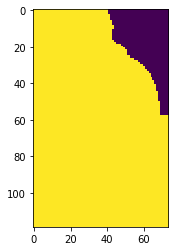

In [44]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio
from scipy import stats

os.chdir('/home/jupyter-rouze')
file='s3://dev-et-data/in/DelawareRiverBasin/Temp/'+ str(year_loop)  + '/' + gTIFF_filename_tasavg;print(file)
with rasterio.open('s3://dev-et-data/in/DelawareRiverBasin/Temp/'+ str(year_loop)  + '/' + gTIFF_filename_tasavg) as src:
    read=src.read(1);print(read)
    print(src.profile)
    plt.imshow(read)
    result = read.ravel() 
    cleanedList = [x for x in result if x != -9999]
    print(stats.describe(cleanedList))
#     show(src)
# reread = rio.open('s3://dev-et-data/in/DelawareRiverBasin/Temp/'+ str(year_loop)  + '/' + gTIFF_filename_tasavg  )

# show(reread)